# Clustering e-commerce's clients

## Business understanding

You have been hired by an e-commerce company that is looking to better understand its customers' behavior in order to personalize its marketing campaigns. To achieve this, the company has provided a CSV database containing data on customers, products, and store transactions carried out between 2010 and 2011.

Based on this data, you need to group customers into clusters according to their purchasing behavior. This will help identify patterns and common characteristics among customers, such as:

- Customers who buy the same products;

- Customers with the same purchase frequency;

- Customers who spend more money on their purchases.

Using these clusters, generate insights that will allow the company to better segment its customer base and personalize its marketing campaigns, directing promotions and offers to customers based on their purchasing behavior.

## Data understanding

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers (https://www.kaggle.com/datasets/carrie1/ecommerce-data).

The table below	provides a detailed description of each column.
<table style='border: 1px solid; margin-left: 0'>
    <thead>
        <tr>
            <th>Column</th>
            <th>Description</th>
            <th>Data Type</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><strong>InvoiceNo</strong></td>
            <td>Transaction ID</td>
            <td>Int</td>
        </tr>
        <tr>
            <td><strong>StockCode</strong></td>
            <td>Product stock code</td>
            <td>String</td>
        </tr>
        <tr>
            <td><strong>Description</strong></td>
            <td>Product description</td>
            <td>String</td>
        </tr>
        <tr>
            <td><strong>Quantity</strong></td>
            <td>Number of products per transaction</td>
            <td>Int</td>
        </tr>
        <tr>
            <td><strong>InvoiceDate</strong></td>
            <td>Transaction date</td>
            <td>Datetime</td>
        </tr>
        <tr>
            <td><strong>UnitPrice</strong></td>
            <td>Unit price of the product</td>
            <td>Float</td>
        </tr>
        <tr>
            <td><strong>CustomerID</strong></td>
            <td>Customer ID</td>
            <td>Int</td>
        </tr>
        <tr>
            <td><strong>Country</strong></td>
            <td>Country of transaction origin</td>
            <td>String</td>
        </tr>
    </tbody>
</table>

#### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Descriptive analysis

In [2]:
# Load data
data = pd.read_csv('../data/raw/data.csv', encoding='latin-1')
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [9]:
# Get basic information about our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The dataset contains 541,909 entries across 8 columns. Some values are missing, and a few columns have incorrect data types. For instance, 'InvoiceDate' should be a datetime, and 'CustomerID' should be an integer. Before proceeding, we will first correct these type errors.

In [3]:
# Correct data types
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['CustomerID'] = data['CustomerID'].astype('Int64')

In [4]:
# Count number of missing values
data.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

We can see that only two columns have missing values. 'CustomerID' is the most affected, with 135,080 missing entries—around 25% of the dataset. 'Description' has 1,454 missing values, accounting for less than 1% of all entries.

In [5]:
# Check for duplicates
print(f'Number of duplicated rows: {data.duplicated(keep=False).sum()}')
data[data.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode']).tail(10)

Number of duplicated rows: 10147


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
411643,C572226,85066,CREAM SWEETHEART MINI CHEST,-1,2011-10-21 13:58:00,12.75,15321,United Kingdom
411644,C572226,85066,CREAM SWEETHEART MINI CHEST,-1,2011-10-21 13:58:00,12.75,15321,United Kingdom
436250,C574095,22326,ROUND SNACK BOXES SET OF4 WOODLAND,-1,2011-11-03 09:54:00,2.95,12674,France
436251,C574095,22326,ROUND SNACK BOXES SET OF4 WOODLAND,-1,2011-11-03 09:54:00,2.95,12674,France
440148,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,2011-11-04 13:25:00,2.95,15110,United Kingdom
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,2011-11-04 13:25:00,2.95,15110,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838,United Kingdom
529980,C580764,22667,RECIPE BOX RETROSPOT,-12,2011-12-06 10:38:00,2.95,14562,United Kingdom
529981,C580764,22667,RECIPE BOX RETROSPOT,-12,2011-12-06 10:38:00,2.95,14562,United Kingdom


We can observe that there are 10,147 duplicated rows in the dataset. Since this is a transaction dataset, duplicates are not expected. These entries may be dropped later.

In [6]:
# Drop duplicated rows
data = data.drop_duplicates()
data[data.duplicated(keep=False)].tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [10]:
# Get basic statistics about data
data[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


As we can observe, there are some issues with the data—both 'Quantity' and 'UnitPrice' contain negative values, which shouldn't occur in this context. Additionally, there are unusually large values in these columns that may indicate anomalies. We'll need to investigate these cases more thoroughly

In [ ]:
# Count unique values
categorical_columns = data.select_dtypes('object').columns
data[categorical_columns].nunique().sort_values(ascending=False)

InvoiceNo      25900
InvoiceDate    23260
Description     4223
StockCode       4070
Country           38
dtype: int64

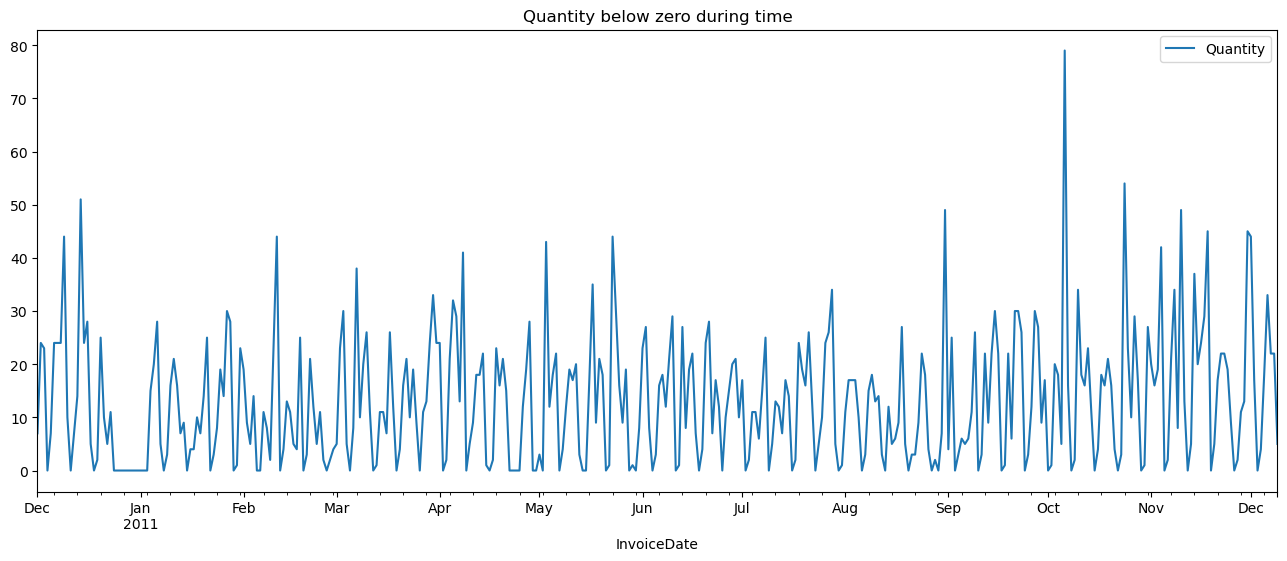

In [37]:
# Verify quantities below zero
data[data['Quantity'] <= 0].groupby('InvoiceDate')[['Quantity']].count().resample('D').count().sort_index().plot(figsize=(16, 6))
plt.title('Quantity below zero during time')
plt.show()